In [11]:
# 1. Import Libraries

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier


# 2. Read and Prepare Data

# Read the dataset
df = pd.read_csv('processed_data_final.csv')  # Replace with your filename

# Drop 'year' and 'customer_id'
df = df.drop(columns=['year', 'customer_id'])

# Separate features (X) and target (y)
# After this line
X = df.drop(columns=['churn'])
y = df['churn']

# Identify categorical columns
categorical_cols = ['gender', 'multi_screen', 'mail_subscribed']


# 3. Encode categorical features BEFORE SMOTE

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # save encoder if needed later

# Replace inf, -inf with NaN
X.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Drop or fill NaN values
X = X.fillna(0).infer_objects(copy=False)


# 4. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Apply SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 6. CatBoost Model Training

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    eval_metric='F1',
    early_stopping_rounds=50,
    verbose=100,
)

# Fit the model
model.fit(X_train_resampled, y_train_resampled)


# 7. Predict Probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probability of class '1'


0:	learn: 0.6962516	total: 171ms	remaining: 2m 50s
100:	learn: 0.9062845	total: 820ms	remaining: 7.3s
200:	learn: 0.9622709	total: 1.44s	remaining: 5.74s
300:	learn: 0.9856322	total: 2.07s	remaining: 4.8s
400:	learn: 0.9938871	total: 2.69s	remaining: 4.01s
500:	learn: 0.9985612	total: 3.29s	remaining: 3.28s
600:	learn: 0.9996402	total: 3.9s	remaining: 2.58s
700:	learn: 1.0000000	total: 4.51s	remaining: 1.92s
800:	learn: 1.0000000	total: 5.19s	remaining: 1.29s
900:	learn: 1.0000000	total: 5.84s	remaining: 642ms
999:	learn: 1.0000000	total: 6.61s	remaining: 0us


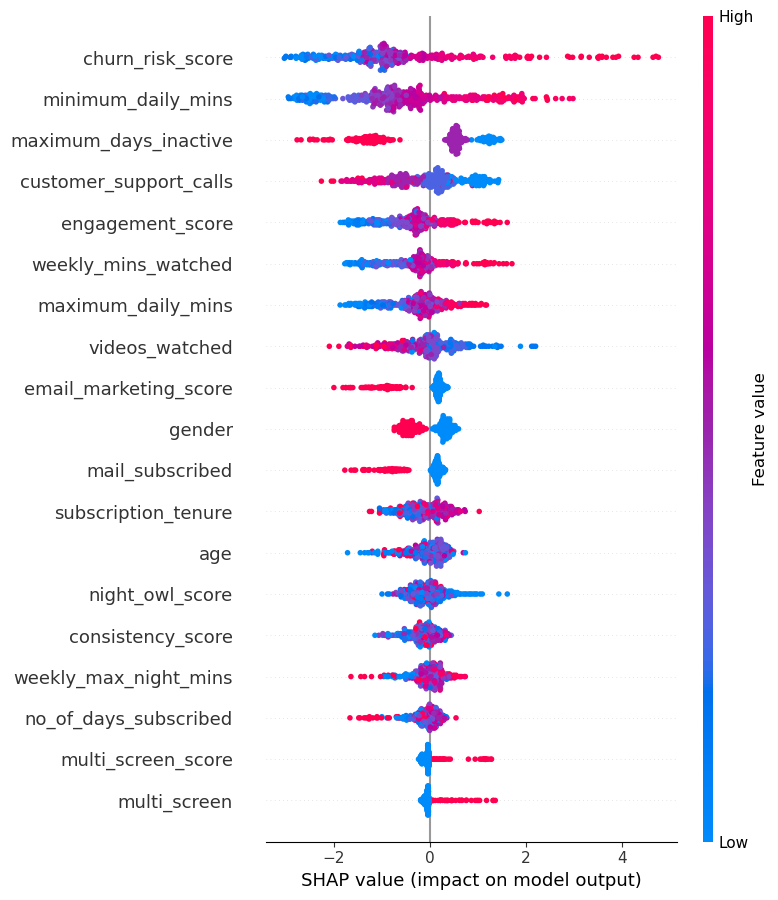

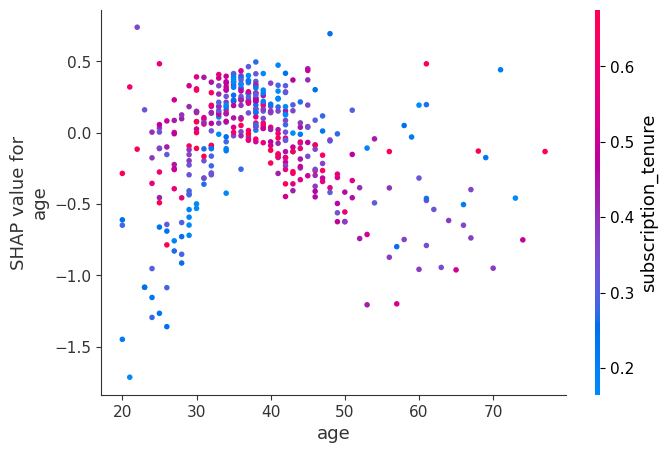

<Figure size 640x480 with 0 Axes>

In [13]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoost model and X_test is your test dataset
# Importing the data (if not already done)
# X_test = pd.read_csv('your_test_data.csv')  # Uncomment if needed

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 1. Summary plot
shap.summary_plot(shap_values, X_test)

# 2. Dependence plot for a single feature, for example 'age'
shap.dependence_plot("age", shap_values, X_test)

# 3. Force plot for the first instance (interactive visualization)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)


# Optional: Save the plots as images
plt.savefig('shap_summary_plot.png')  # Save summary plot


<Figure size 600x500 with 0 Axes>

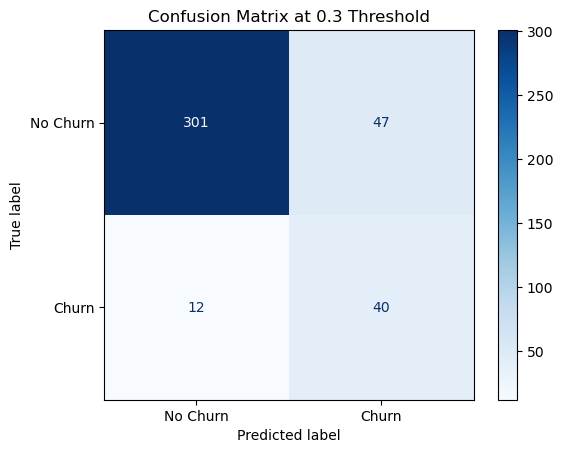

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test are the true labels, and y_pred_proba are predicted probabilities from CatBoost
from catboost import CatBoostClassifier

# Apply threshold to get predicted class labels
threshold = 0.3
y_pred = (y_pred_proba >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix at 0.3 Threshold')
plt.show()


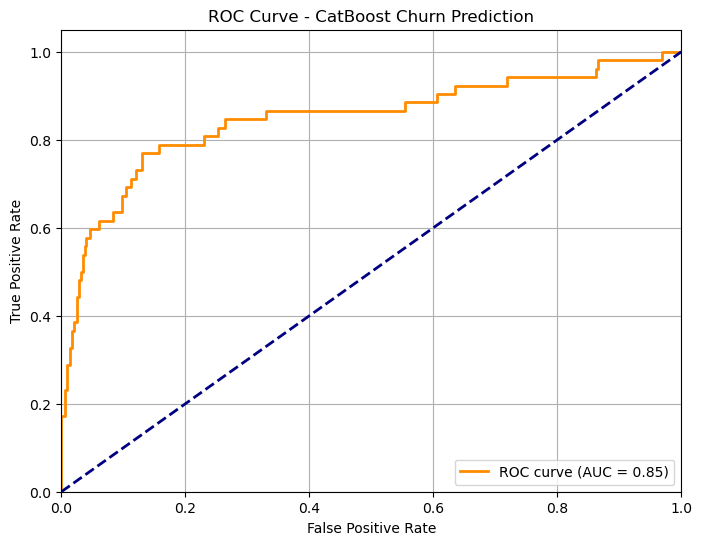

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# actual variables
y_true = y_test  # True labels from the test set
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (Churn)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost Churn Prediction')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
